# AI Makerspace - Unsloth GRPO Training

In this notebook, we will use the work done by Unsloth to walk through a small scale sample of the DeepSeek-R1 process outlined in their paper.

This is not a direct 1-to-1, but it does outline the major innovations in the paper.

Let's dive in!

### What is the GRPO Training Process with RL?

1. Group Sampling: For a single prompt or state, the policy generates a batch of outputs (instead of just one). This produces a small “group” of possible actions or answers.

2. Reward Scoring: Each output is scored by a reward function, which reflects how good or desirable that output is for the task at hand.

3. Group-Based Advantage: The algorithm calculates each output’s “advantage” by comparing its reward to the average reward of the entire group. If the output’s reward is above average, it has a positive advantage (and vice versa).

4. Policy Update: The policy is adjusted to promote outputs with a positive advantage and discourage those with a negative advantage. A KL penalty term prevents the policy from changing too drastically.

5. Iterative Process: The updated policy is used again to generate new groups, score them, and update—repeating until the policy converges or meets performance goals.

This group-based approach removes the need for a separate value function (critic) and helps the policy quickly learn which outputs are relatively better within each sampled group.

# 🤝 BREAKOUT ROOM #1

> NOTE: A lot of the cells will take 1min. or more to run. This is expected!

### Overview of PEFT and LoRA:

Based on some awesome research [here](https://github.com/huggingface/peft), we can leverage techniques like PEFT and LoRA to train/fine-tune large models a lot more efficiently.

It can't be explained much better than the overview given in the above link:

```
Parameter-Efficient Fine-Tuning (PEFT) methods enable efficient adaptation of
pre-trained language models (PLMs) to various downstream applications without
fine-tuning all the model's parameters. Fine-tuning large-scale PLMs is often
prohibitively costly. In this regard, PEFT methods only fine-tune a small
number of (extra) model parameters, thereby greatly decreasing the
computational and storage costs. Recent State-of-the-Art PEFT techniques
achieve performance comparable to that of full fine-tuning.
```

### Installation

As you can see, we'll only need a few dependencies thanks to the collective hard work of the community!

In [1]:
%%capture
# Skip restarting message in Colab
import sys; modules = list(sys.modules.keys())
for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None

!pip install "unsloth==2025.2.12" vllm
!pip install --upgrade pillow
# If you are running this notebook on local, you need to install `diffusers` too
# !pip install diffusers
# Temporarily install a specific TRL nightly version
!pip install git+https://github.com/huggingface/trl.git@e95f9fb74a3c3647b86f251b7e230ec51c64b72b

### Unsloth

Use [`PatchFastRL`](https://github.com/unslothai/unsloth/blob/646ad2f141a3a0721d1ec9449cf9454b5612a84a/unsloth/models/rl.py#L44) before all functions to patch GRPO and other RL algorithms!

> NOTE: This patch overwrites the TRL `.generate` to be a bit more optimized. Classic Unsloth!

In [2]:
from unsloth import FastLanguageModel, PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)

Unsloth: Patching Xformers to fix some performance issues.
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 02-18 20:44:54 __init__.py:190] Automatically detected platform cuda.


## Task #1: Loading the Model

In the following task you will be expected to load the model from Hugging Face.

### Overview of Quantization:

Quantization is ultimately a simple concept with some very clever and tricky techniques that power it.

In today's notebook, we'll be exclusively focusing on the `bitsandbytes` quantization strategy which includes the idea of `k-bit` training.

Let's look at the QLoRA paper's definition of quantization:


```
Quantization is the process of discretizing an input from a representation that
holds more information to a representation with less information
```

Easy enough then!

Let's take a look at what that actually means.

### Block-wise k-bit Quantization

Ultimately, the QLoRA paper relies on a very specific form of quantization that relies on a few key ideas:

1. Model weights are mostly normally distributed
2. NF4 is a information-theoretically optimal data-type (this was later found to be [untrue](https://x.com/Tim_Dettmers/status/1668649436724199425?s=20), but NF4 is close to *empirically* optimal)


Let's think about quantization from a very high level - and use some oversimplifications to understand what's really happening under the hood.

In essence, we can think of quantization as placing a pin on the number line (our quantization constant) and then expressing a low-precision zero-centered size-64 block range around that pinned number. Exploiting the fact that our weights are normally distributed and that we scale them to be in the range [-1, 1], this lets use use our NF4 datatype to roughly optimally express our high precision weights in a low precision format. While we still do need *some* higher precision numbers - this process lets use represent many numbers in low precision for the cost of 1 number in high precision.

However, we can take it one step further - and we can actually quantize the range of quantization constants we wind up with as well! This winds up saving us ~0.373 bits per parameter.

#### Initializing LoRA Config

There's a lot to unpack here - so let's talk about the main parameters:

- `r`: is the "rank" of the two decomposed matrices we'll be using to represent our weight matrix. In reality, this is the dimension of the decomposed matrices.

Here is an exerpt from the paper to help provide context for the selected `r`

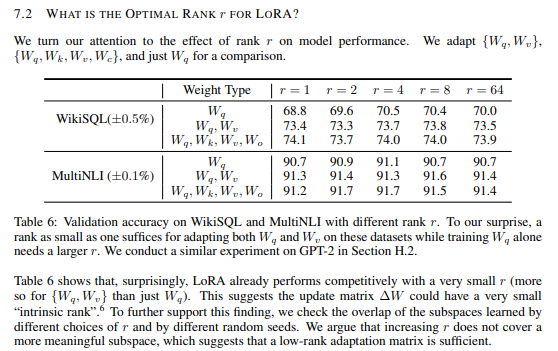


- `target_modules`: As LoRA can be applied to *any* weight matrix - we need to configure *which* module (weight matrix) it's being applied to. The LoRA paper suggests applying it to the Attention weights, but the QLoRA paper suggests we apply it to all Linear layers. Thus, we'll omit `target_module` from our hyper-parameters.


- `task_type`: This is a derived property. If you're using a causal model, this should be set to `CAUSAL_LM`. Please ensure this property is set based on your selected model.

Again, while this is the way we're leveraging LoRA in this notebook - it can be used in conjunction with many different models - and many different tasks. You can even use it for tasks like [token classification!](https://huggingface.co/docs/peft/task_guides/token-classification-lora)

Leveraging the work done in [QLoRA](https://arxiv.org/pdf/2305.14314.pdf) means we need to set some specific hyper-parameters for our [`quantization_config`](https://github.com/huggingface/transformers/blob/2fc33ebead50383f7707b17f0e2a178d86347d10/src/transformers/utils/quantization_config.py#L151).

- `load_in_4bit` - we'll want to set this to true so we can load and train our model on a single 16GB GPU.



In [3]:
from unsloth import is_bfloat16_supported
import torch
max_seq_length = 512 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "meta-llama/meta-Llama-3.1-8B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.6, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ], # Remove QKVO if out of memory
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", # Enable long context finetuning
    random_state = 3407,
)

==((====))==  Unsloth 2025.2.12: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4bit with actual GPU utilization = 59.37%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 512. Num Sequences = 288.
Unsloth: vLLM's KV Cache can use up to 17.31 GB. Also swap space = 6 GB.
INFO 02-18 20:45:29 config.py:542] This model supports multiple tasks: {'generate', 'embed', 'classify', 'score', 'reward'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes config us

tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

INFO 02-18 20:45:35 cuda.py:230] Using Flash Attention backend.
INFO 02-18 20:45:35 model_runner.py:1110] Starting to load model unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4bit...
INFO 02-18 20:45:35 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 02-18 20:45:37 weight_utils.py:252] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-18 20:46:01 model_runner.py:1115] Loading model weights took 5.5976 GB
INFO 02-18 20:46:01 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 02-18 20:46:10 worker.py:267] Memory profiling takes 8.32 seconds
INFO 02-18 20:46:10 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.59) = 23.49GiB
INFO 02-18 20:46:10 worker.py:267] model weights take 5.60GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 1.33GiB; the rest of the memory reserved for KV Cache is 16.46GiB.
INFO 02-18 20:46:10 executor_base.py:110] # CUDA blocks: 8429, # CPU blocks: 3072
INFO 02-18 20:46:10 executor_base.py:115] Maximum concurrency for 512 tokens per request: 263.41x
INFO 02-18 20:46:14 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error o

Capturing CUDA graph shapes: 100%|██████████| 39/39 [00:51<00:00,  1.31s/it]

INFO 02-18 20:47:05 model_runner.py:1562] Graph capturing finished in 51 secs, took 0.89 GiB
INFO 02-18 20:47:05 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 64.57 seconds


tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth 2025.2.12 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [4]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(
  

In [5]:
model.config

LlamaConfig {
  "_name_or_path": "unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4bit",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "quantization_config": {
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "

#### ❓Question #1:

What exactly is happening in the double quantization step?

load_in_4bit=True specifies that the model's weights should be quantized to 4-bit integers. This means each weight is represented using only 4 bits, drastically reducing the model's size.

The quantization constants themselves (the values used to map the 4-bit integers back to approximate floating-point numbers) are also quantized. These constants are typically stored in FP16, but they can also be quantized to save even more memory. This second quantization of the constants is what sometimes gets referred to as "double quantization." It's not quantizing the weights twice, but quantizing the quantization parameters.


#### ❓Question #2:

![image](https://i.imgur.com/N8y2crZ.png)

Label the image with the appropriate layer from `meta-llama/Llama-3.1-8B-Instruct`'s architecture.

- Text & Position Embed: It takes the input text and converts it into numerical embeddings, also incorporating positional information.

- Masked Multi Self-Attention: This corresponds to the "Attention" blocks in the diagram.  Llama models use masked multi-head self-attention mechanisms to allow the model to attend to different parts of the input sequence while respecting the causal mask (i.e., not attending to future tokens).  Each "Attention" block in the image is a "Masked Multi Self-Attention" layer.

- Feed Forward: This corresponds to the "FFN" (Feed-Forward Network) blocks in the diagram.  These are fully connected feed-forward networks applied after the attention mechanism. Each "FFN" block in the image is a "Feed Forward" layer.

- Layer Norm:  Llama models use RMSNorm (Root Mean Square Normalization) layers for normalization.  In the diagram, the "Add & Norm" blocks represent the combination of adding the residual connection and applying layer normalization.  So, each "Add & Norm" block contains a Layer Norm (specifically, LlamaRMSNorm in Llama models).  We would have three instances of Layer Norm within each numbered block in the image.

(input_layernorm): LlamaRMSNorm() (Normalization before the attention mechanism)
(post_attention_layernorm): LlamaRMSNorm() (Normalization after the attention mechanism)
(norm): LlamaRMSNorm() or similar (Normalization after the FFN)

- Text Prediction: This would occur after the final numbered block (layer) in the diagram.  The diagram doesn't explicitly show it, but the output of the last layer is typically passed through a linear layer (and sometimes a softmax) to predict the next token in the sequence. This is the "Text Prediction" part.

#### ❓Question #3:

What modules (or groupings of layers) did we apply LoRA too - and how can we tell from the model summary?

Attention Mechanism (within each LlamaDecoderLayer):

- q_proj: Query projection
- k_proj: Key projection
- v_proj: Value projection
- o_proj: Output projection

Feed-Forward Network (MLP, within each LlamaDecoderLayer):

- gate_proj: Gate projection
- up_proj: Up projection
- down_proj: Down projection

Each lora.Linear contains:

(base_layer): Linear4bit(...): This shows the original linear layer (now frozen).

- (lora_A): This is the LoRA "A" matrix.
- (lora_B): This is the LoRA "B" matrix.

The presence of these lora_A and lora_B matrices within the linear layers indicates that LoRA is applied to those layers.  The lora_dropout indicates the LoRA dropout setting.  The lora_embedding_A, lora_embedding_B, lora_magnitude_vector are for embedding layers (which you don't have LoRA applied to).

# 🤝 BREAKOUT ROOM #2

### Data Preparation

You'll notice a peculiarity here - our dataset is just...inputs and outputs! (specifically from the GSM8K data).

But wait, we said this was different from SFT - but this is seemingly just SFT all over again!

Well, we still need questions and answers to verify that we're learning *something* productive - but importantly, we are not leveraging a specific human preference reward model, or process reward model to bake our responses into the model - we just need a way to verify if an answer provided by our model was correct or incorrect. A way, to *reward* correct generations!

For now, let's examine what our input data looks like.

> NOTE: Unsloth directly leveraged the work that [@willccbb](https://gist.github.com/willccbb/4676755236bb08cab5f4e54a0475d6fb) did, for data prep and all reward functions.

In [6]:
import re
from datasets import load_dataset, Dataset

# This string defines the instructions for formatting responses.
# Responses should include two parts: reasoning and answer, each wrapped in XML-like tags.
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

# This template provides a way to format the response with placeholders for reasoning and answer.
XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

def extract_xml_answer(text: str) -> str:
    """
    Extracts and returns the text between the <answer> and </answer> tags.

    Steps:
    1. Splits the input text at the <answer> tag and takes the last part.
    2. Splits the result at the </answer> tag.
    3. Strips any extra whitespace and returns the cleaned answer.
    """
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def extract_hash_answer(text: str) -> str | None:
    """
    Looks for the marker '####' in the input text.

    If found:
    - Splits the text on '####' and returns the portion after the marker, stripped of whitespace.
    If not found:
    - Returns None.
    """
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

# uncomment middle messages for 1-shot prompting
def get_gsm8k_questions(split = "train") -> Dataset:
    """
    Loads the GSM8K dataset (grade school math problems) and processes each item.

    For each problem in the dataset:
    1. Creates a prompt with two messages:
       - A system message containing the response formatting instructions.
       - A user message containing the question.
    2. Extracts the answer using the 'extract_hash_answer' function.

    Returns:
        The processed dataset with each entry containing the formatted prompt and extracted answer.
    """
    data = load_dataset('openai/gsm8k', 'main')[split] # type: ignore
    data = data.map(lambda x: { # type: ignore
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }) # type: ignore
    return data # type: ignore

dataset = get_gsm8k_questions()

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

As you can see in this data, there is no specific information about preference, or "how to reason", or anything close to it. It's simply the question and the answer.

This is the core idea behind this style of training - we're not going to give the model *how* to think as an example - we're simply going to let it play in a sandbox defined by the question and answer.

> NOTE: This is not the case for DeepSeek-R1, where there is a *very small* amount of SFT that occurs (called the "cold-start") to "prime" the model for the subsequent RL stage of training.

In [7]:
dataset[0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': '72',
 'prompt': [{'content': '\nRespond in the following format:\n<reasoning>\n...\n</reasoning>\n<answer>\n...\n</answer>\n',
   'role': 'system'},
  {'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
   'role': 'user'}]}

Now we get to the *magic* of the approach - a collection of reward models.

Notice that we have a number of different "checks" we do - these come together as expressed in the following diagram:

![image](https://i.imgur.com/7Dp0qdt.png)

What this means, essentially, is that we use a suite of reward functions to determine if our model is learning "how we want", as opposed to giving it examples that show it how we want it to learn.

These reward functions are totally customizable - and allow users to effectively steer how and what the model is incentivized to "get good at".

In [8]:
# Reward functions
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    """
    This function evaluates the correctness of the model's response.

    Steps:
    - It extracts the content of the first message from each completion.
    - It then extracts the answer from the XML-formatted response using the extract_xml_answer function.
    - For debugging, it prints the original question, the expected answer, the raw response, and the extracted answer.
    - Finally, it compares the extracted response to the expected answer and assigns a reward of 2.0 if they are equal, otherwise 0.0.
    """
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

def int_reward_func(completions, **kwargs) -> list[float]:
    """
    This function rewards responses that are purely numeric.

    Steps:
    - It extracts the content of the first message from each completion.
    - It extracts the answer from the XML-formatted response.
    - It checks if the extracted answer is a digit (i.e., a numeric string) and returns a reward of 0.5 if it is, otherwise 0.0.
    """
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """
    This function rewards responses that exactly follow a strict XML format.

    Steps:
    - It uses a regular expression pattern that enforces the precise structure:
      The response must start with <reasoning> on its own line, followed by some text,
      then </reasoning> on its own line, then <answer> on its own line, some text,
      and finally </answer> on its own line, with no extra content before or after.
    - It returns a reward of 0.5 if the response exactly matches this pattern, otherwise 0.0.
    """
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """
    This function rewards responses that generally follow the expected XML format.

    Steps:
    - It uses a more relaxed regular expression pattern that checks for the presence of <reasoning> and </reasoning>
      followed by <answer> and </answer> somewhere in the text.
    - It returns a reward of 0.5 if the pattern is found, otherwise 0.0.
    """
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def count_xml(text) -> float:
    """
    This helper function calculates a reward score based on the presence and exact count
    of specific XML formatting markers in the text.

    Steps:
    - It checks if the text contains exactly one occurrence of each of the tags with newlines:
      "<reasoning>\n", "\n</reasoning>\n", "\n<answer>\n", and "\n</answer>".
    - It adds 0.125 to the count for each correctly placed tag.
    - For the <answer> and </answer> tags, it subtracts a small penalty based on the length of the text
      following the closing tags.
    - Returns the total score.
    """
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    """
    This function applies the count_xml helper function to each completion.

    Steps:
    - It extracts the content of the first message from each completion.
    - It computes a reward score for each response by counting the XML formatting elements using count_xml.
    - Returns a list of reward scores.
    """
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

### Train the model

All that is left to do, now that we have our:

1. Training examples
2. Reward Functions

Is to train our model!

We'll start with setting a number of hyper-parameters.

> NOTE: These hyper-parameters are based around the free-tier Colab T4 instance, you can modify them to "right size" to your hardware.

### GPROConfig

First and foremost - we have a number of typical hyper-parameters (as always).

You'll also notice a distinct *lack* of GRPO hyper-parameters being used in this implementation - we'll stick with the defaults to keep this notebook manageable, but you're welcome to dive deep into TRL and play around to see what works best for your use-case.

> NOTE: If you wish to walk away with the classic "RL" image of "line going up to the right", you can remove the `report_to = "none"` from the following config.This will require you to have a Weights and Biases API key - which you can get by following [this](https://docs.wandb.ai/quickstart/) process.

In [9]:
from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    use_vllm = True, # use vLLM for fast inference!
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "paged_adamw_8bit",
    logging_steps = 1,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1, # Increase to 4 for smoother training
    num_generations = 6, # Decrease if out of memory
    max_prompt_length = 256,
    max_completion_length = 200,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 250,
    save_steps = 250,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",
)

#### ❓Question #4:

Describe what the following parameters are doing:

- warmup_ratio (float, optional, defaults to 0.0) — Ratio of total training steps used for a linear warmup from 0 to learning_rate.
- learning_rate (float, optional, defaults to 5e-5) — The initial learning rate for AdamW optimizer.
- lr_scheduler_type (str or SchedulerType, optional, defaults to "linear") — The scheduler type to use. See the documentation of SchedulerType for all possible values.

> NOTE: Feel free to consult the [documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) or other resources!

Finally, we can run our trainer!

The basic idea in this RL focused approach is that, instead of watching loss go down, we want to watch reward *go up!*.

> NOTE: The training has a kind of "Aha!" moment, as it's been described, whereby the reward goes from ~0 and then suddenly begins increasing. This is expected behaviour - but you may not see changes in the reward column (the combined output of our above define reward functions) until you get past the 100th-150th step.

In [10]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 7,473 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 250
 "-____-"     Number of trainable parameters = 83,886,080


-------------------- Question:
A concert ticket costs $40. Mr. Benson bought 12 tickets and received a 5% discount for every ticket bought that exceeds 10. How much did Mr. Benson pay in all? 
Answer:
476 
Response:
Let's break this down step by step:

1. Mr. Benson bought 12 tickets, but the discount only applies to the tickets beyond 10. So, the first 10 tickets are full price, and the last 2 tickets get a 5% discount.

2. The cost of the first 10 tickets:
10 tickets x $40 per ticket = $400

3. To find the cost of the two tickets with a 5% discount, first, we need to find the discounted price of one ticket:
   Original price of one ticket = $40
   Discount = 5% of $40 = 0.05 x $40 = $2
   Discounted price of one ticket = Original price - discount = $40 - $2 = $38

4. Now, we can calculate the cost of the two discounted tickets:
   Cost of 2 discounted tickets = 2 x $38 = $76

5. To find the total cost, 
Extracted:
Let's break this down step by step:

1. Mr. Benson bought 12 tickets, 

Step,Training Loss,reward,reward_std,completion_length,kl,rewards / xmlcount_reward_func,rewards / soft_format_reward_func,rewards / strict_format_reward_func,rewards / int_reward_func,rewards / correctness_reward_func
1,0.000000,0.000000,0.000000,171.333344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.020833,0.051031,198.166672,0.000000,0.020833,0.000000,0.000000,0.000000,0.000000
4,0.000000,1.203500,1.234677,167.000000,0.000341,-0.046500,0.000000,0.000000,0.250000,1.000000
5,0.000100,0.080833,0.145295,101.500000,0.001588,-0.002500,0.000000,0.000000,0.083333,0.000000
6,0.000000,0.854167,1.275776,183.000000,0.000286,0.020833,0.000000,0.000000,0.166667,0.666667
7,0.000000,0.000000,0.000000,198.833344,0.000320,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.322667,1.075622,139.666672,0.000697,-0.094000,0.000000,0.000000,0.083333,0.333333
9,0.000000,0.854167,1.275776,163.500000,0.000424,0.020833,0.000000,0.000000,0.166667,0.666667
10,0.000000,0.000000,0.000000,200.000000,0.000284,0.000000,0.000000,0.000000,0.000000,0.000000


Streaming output truncated to the last 5000 lines.
Sunday earnings = 14 hours * $15/hour = $210

To find the total earnings, add up the earnings from each day:
Total earnings = Friday earnings + Saturday earnings + Sunday earnings = $150 + $90 + $210 = $450

Answer: $450 
Extracted:
To find out the total amount of money Sandy earned, we need to calculate the amount she earned on each day and sum them up.

On Friday, Sandy worked 10 hours at $15 per hour. 
Friday earnings = 10 hours * $15/hour = $150

On Saturday, Sandy worked 6 hours at $15 per hour.
Saturday earnings = 6 hours * $15/hour = $90

On Sunday, Sandy worked 14 hours at $15 per hour.
Sunday earnings = 14 hours * $15/hour = $210

To find the total earnings, add up the earnings from each day:
Total earnings = Friday earnings + Saturday earnings + Sunday earnings = $150 + $90 + $210 = $450

Answer: $450
-------------------- Question:
Michael has $42. Michael gives away half the money to his brother. His brother then buys 3 doll

TrainOutput(global_step=250, training_loss=0.0008882170465888848, metrics={'train_runtime': 2440.3079, 'train_samples_per_second': 0.102, 'train_steps_per_second': 0.102, 'total_flos': 0.0, 'train_loss': 0.0008882170465888848})

You can see our Reward Curve here:

![image](https://i.imgur.com/Gv7HOzJ.png)

As you can see, this is a quite noisey training run at this scale on this hardware - but the general pattern of "up to the right" is clearly visible in our rewards over time!

<a name="Inference"></a>
### Inference
Now let's try the model we just trained! First, let's first try the model without any GRPO trained:

In [11]:
text = tokenizer.apply_chat_template([
    {"role" : "user", "content" : "Calculate pi!"},
], tokenize = False, add_generation_prompt = True)

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 1024,
)
output = model.fast_generate(
    [text],
    sampling_params = sampling_params,
    lora_request = None,
)[0].outputs[0].text

output

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.20s/it, est. speed input: 6.29 toks/s, output: 73.90 toks/s]


'Calculating Pi:\n===============\n\nThere are many ways to calculate Pi. Here\'s a simple approach using the Monte Carlo method, which is a numerical method that estimates Pi by throwing random points onto a circle and counting the ratio of points inside the circle to the total number of points.\n\n### Code\n\n```python\nimport random\nimport math\n\ndef estimate_pi(num_points):\n    """\n    Estimates Pi using the Monte Carlo method.\n\n    Args:\n        num_points (int): The number of random points to generate.\n\n    Returns:\n        float: An estimate of Pi.\n    """\n    points_inside_circle = 0\n    for _ in range(num_points):\n        x, y = random.random(), random.random()\n        distance = x**2 + y**2\n        if distance <= 1:\n            points_inside_circle += 1\n    return 4 * points_inside_circle / num_points\n\n# Example usage\nnum_points = 1000000\nestimated_pi = estimate_pi(num_points)\nprint(f"Estimated Pi: {estimated_pi}")\nprint(f"Actual Pi (approx): {math.pi}

And now with the LoRA we just trained with GRPO - we first save the LoRA first!

In [12]:
model.save_lora("grpo_saved_lora")

Now we load the LoRA and test:

In [13]:
text = tokenizer.apply_chat_template([
    {"role" : "system", "content" : SYSTEM_PROMPT},
    {"role" : "user", "content" : "Calculate pi"},
], tokenize = False, add_generation_prompt = True)

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 1024,
)
output = model.fast_generate(
    text,
    sampling_params = sampling_params,
    lora_request = model.load_lora("grpo_saved_lora"),
)[0].outputs[0].text

output

Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.49s/it, est. speed input: 10.93 toks/s, output: 67.57 toks/s]


'There is no single formula to calculate pi exactly, as it is an irrational number that goes on forever without a repeating pattern. However, there are several mathematical formulas and algorithms that can approximate pi with varying degrees of accuracy.\n\nOne of the most well-known formulas for calculating pi is the Leibniz formula, which is:\n\n<math display="block">\nπ = 4 \\* (1 - \\frac{1}{3} + \\frac{1}{5} - \\frac{1}{7} + \\frac{1}{9} - \\cdots)\n</math>\n\nThis is an infinite series, which can be approximated by summing up a large number of terms.\n\nAnother formula for calculating pi is the Gregory-Leibniz series:\n\n<math display="block">\nπ = \\sum_{n=0}^{\\infty} \\frac{(-1)^n}{2n + 1} = 4 \\* \\sum_{n=0}^{\\infty} \\frac{(-1)^n}{2n + 1}\n</math>\n\nThis formula is similar to the Leibniz formula, but it uses a different pattern of signs.\n\nIn modern times, the most accurate calculations of pi have been done using powerful computers and advanced mathematical algorithms. As

And in classic fashion - the "reasoning model" is better at the task than the non-reasoning variant.

Check out that calculation of pi:

![image](https://i.imgur.com/6iAFJj7.png)

All this inside of an hour in a Colab instance - this is the power of Open Source!